# Post-processing

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

Load libraries

In [549]:
from fastai.imports import *
from fastai.structured import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from dill import load_session, dump_session

Load environment

In [66]:
load_session('tmp/globalsave.pkl')

## Results post-processing (tl;dr)
 __Goal: understand which surroundings lead to top perfomance POS.__
        - Filtered POSs without surrounding info
        - For each POS we aggregated sales over time (problem to distinguish between open day or not selling day)
        - Filter POSs without enough selling data points (more than 120 open days).
        - Final dataset with 479 POSs.
        
        
Info about geo location of the shop, to calculate distance from surroundings location.

## Preparation of final dataset

### Filter POSs without surrounding 

Check how many POSs with surroundings info

In [7]:
POSs_y = list(df_aggregate_per_day_short.store_code.unique())
POSs_surr = list(metadata_no_day.store_code)

len(POSs_y), len(POSs_surr), sum([x in POSs_surr for x in POSs_y]), round(sum([x in POSs_surr for x in POSs_y])/len(POSs_y),3)

(903, 546, 539, 0.597)

Info about surroudings for ~59% POSs.

In [8]:
POSs_with_surr_no_y = list(set(POSs_surr)-set(POSs_y))
POSs_with_surr_no_y.sort()
POSs_with_surr_no_y

[12028, 15133, 20447, 24370, 29459, 32289]

For 6 POSs we have info about the surroundings but without information on selling. 


_Since the goal of the analysis is to understand which surroundings leads to top POS performances, we removed from all further analyses the POSs without surrounding information._

In [9]:
df_aggregate_per_day_short_with_info = df_aggregate_per_day_short[df_aggregate_per_day_short.store_code.isin(POSs_surr)]

### Closing vs not-selling days?
Investigate how many days POS open.

In [10]:
def get_lag(shop):
    d = {}
    d['days'] = (max(shop['date']) - min(shop['date'])).days  + 1
    d['days_sell'] = np.count_nonzero(shop['volume_day'])
    d['volume_tot'] = sum(shop['volume_day'])
    return pd.Series(d, index = ['days','days_sell','volume_tot'])


flds = ['store_code','volume_day','date']
df_shops_days = df_aggregate_per_day_short_with_info[flds].groupby('store_code').apply(get_lag).reset_index()
df_shops_days['prop_selling_days'] = df_shops_days.days_sell/df_shops_days.days
df_shops_days.sort_values('days',inplace=True)
df_shops_days.head(80)

,store_code,days,days_sell,volume_tot,prop_selling_days
39,11007,1.0,1.0,60.0,1.000000
16,4032,1.0,1.0,30.0,1.000000
12,3745,1.0,1.0,30.0,1.000000
496,32357,1.0,1.0,300.0,1.000000
11,3655,2.0,2.0,90.0,1.000000
15,4013,3.0,3.0,420.0,1.000000
2,1498,4.0,3.0,360.0,0.750000
4,2331,4.0,2.0,60.0,0.500000
14,3958,4.0,3.0,240.0,0.750000
8,3075,5.0,5.0,390.0,1.000000


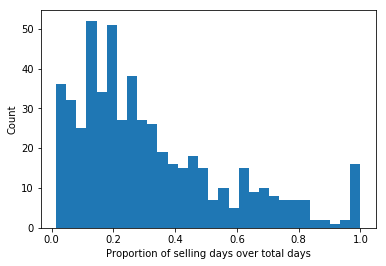

In [11]:
plt.hist(df_shops_days.prop_selling_days, bins=30);
plt.xlabel('Proportion of selling days over total days');
plt.ylabel('Count');

We have around 15 POSs with all the days selling. But still several POSs were the proportion of selling days is low.

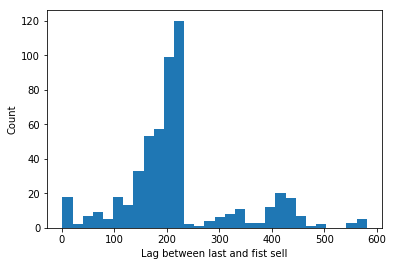

In [12]:
plt.hist(df_shops_days.days, bins = 30);
plt.xlabel('Lag between last and fist sell');
plt.ylabel('Count');

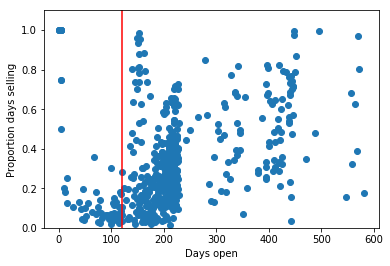

In [13]:
plt.scatter(df_shops_days.days, df_shops_days.prop_selling_days)
plt.ylim(0,1.1)
plt.xlabel('Days open')
plt.ylabel('Proportion days selling');
plt.axvline(x=120, color = 'red');

We still see that for several POSs we have few selling days, although we deleted already all the days before the first sell and after the last one.

This might be due to the fact that some shops closed in specific days of the week (i.e. Sundays), but it might be due to missing values into the time seris.

We __discard all the shops with less than 120 of opening days__, since they might bias our analysis: additional 61 shops.

In [338]:
df_shops_days_filer = df_shops_days[df_shops_days.days >= 120]
df_shops_days.shape[0] - df_shops_days_filer.shape[0]

In [340]:
#df_shops_days_filer['norm_volume_all_days'] = np.log(df_shops_days_filer.volume_tot/df_shops_days_filer.days)
#df_shops_days_filer['norm_volume_selling_days'] = np.log(df_shops_days_filer.volume_tot/df_shops_days_filer.days_sell)

In [341]:
df_shops_days_filer.head()

,store_code,days,days_sell,volume_tot,prop_selling_days,norm_volume_all_days,norm_volume_selling_days
359,28627,120.0,4.0,120.0,0.033333,0.000000,3.401197
199,22011,121.0,8.0,330.0,0.066116,1.003302,3.719651
314,27056,121.0,13.0,930.0,0.107438,2.039394,4.270235
131,19747,121.0,34.0,2490.0,0.280992,3.024247,4.293677
297,26665,125.0,25.0,2370.0,0.200000,2.942331,4.551769


In [267]:
df_aggregate_per_day_short_with_info_filter = df_aggregate_per_day_short_with_info[df_aggregate_per_day_short_with_info.store_code.isin(df_shops_days.store_code)]

### Seasonality

In [342]:
def all_POSs_aggregate(x):
    d = {}
    d['Dayofweek'] = x['Dayofweek'].iloc[0]
    d['n_shops'] = x['store_code'].nunique()
    d['n_open_shops'] = np.count_nonzero(x['volume_day'])
    d['tot_volume'] = x['volume_day'].sum()
    return pd.Series(d, index=['Dayofweek','n_shops','n_open_shops','tot_volume'])

seasonality = df_aggregate_per_day_short_with_info_filter.groupby('date').apply(all_POSs_aggregate)
seasonality['norm_volume'] = seasonality.tot_volume/seasonality.n_shops
seasonality['norm_volume_open'] = seasonality.tot_volume/seasonality.n_open_shops
seasonality.head()

,Dayofweek,n_shops,n_open_shops,tot_volume,norm_volume,norm_volume_open
date,,,,,,
2015-11-23,0.0,1.0,1.0,300.0,300.0,300.0
2015-11-24,1.0,1.0,0.0,0.0,0.0,NaN
2015-11-25,2.0,1.0,0.0,0.0,0.0,NaN
2015-11-26,3.0,1.0,0.0,0.0,0.0,NaN
2015-11-27,4.0,1.0,0.0,0.0,0.0,NaN


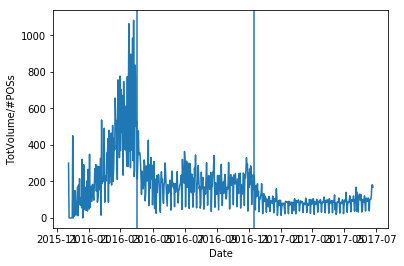

In [343]:
plt.plot(seasonality.norm_volume);
plt.axvline(x='2016-11-10');
plt.axvline(x='2016-04-01');
plt.xlabel('Date');
plt.ylabel('TotVolume/#POSs');

We see big variability at the beginning of the time series, suggesting a seasonality effect (ups and downs). 
The down picks are due to the sundays.

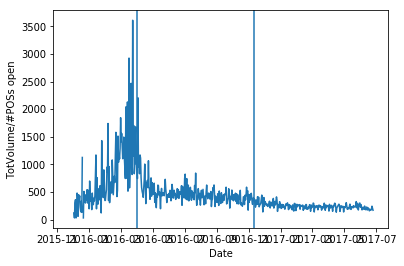

In [344]:
plt.plot(seasonality.norm_volume_open);
plt.axvline(x='2016-11-10');
plt.axvline(x='2016-04-01');
plt.xlabel('Date');
plt.ylabel('TotVolume/#POSs open');

In this plot, we normalized the volume by the shops that sold something, since we don't know if no sell is shop closed or shop not selling.

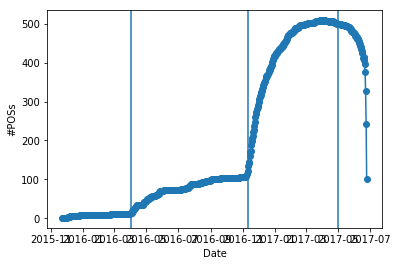

In [360]:
plt.plot(seasonality.n_shops, marker = 'o')
plt.axvline(x='2016-11-10');
plt.axvline(x='2016-04-01');
plt.xlabel('Date');
plt.ylabel('#POSs');

When we control for the number of shops for each time point, we clearly see that the big variability observed at the beginning is due to few observation available. It seems that more and more information were available along time. It seems that the information about sell started to be increased by the end of 2016 (vertical line on the 10th November 2016). Already at April 2016 we see an increase in the number of shops. The last drop we see at the end of the time series might be due to just lag in receiving information.

We focus only on the time frame from the 2016-04-01 until the last day.

In [347]:
df_aggregate_per_day_short_with_info_filter = df_aggregate_per_day_short_with_info_filter[df_aggregate_per_day_short_with_info_filter.date > '2016-04-01']

In [351]:
df_aggregate_per_day_short_with_info_filter.columns

Index(['store_code', 'date', 'volume_day', 'volume_nan', 'volume_n',
       'Perc_nan', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype='object')

## Analysis

### First model:
Use volume per day, with time info (i.e. Dayofweek) and number of surrondings for each type, with the corresponding time they open.

In [398]:
flds_POSs = ['store_code','date','volume_day','Year','Month','Week','Day','Dayofweek','Is_month_end',
             'Is_month_start','Is_quarter_end','Is_quarter_start','Is_year_end','Is_year_start']

In [467]:
metadata_simple = pd.concat([metadata_with_days.store_code, metadata_with_days.Dayofweek, metadata_with_days.filter(regex="_n")], axis = 1)
metadata_simple.fillna(0, inplace=True)
final_with_time = df_aggregate_per_day_short_with_info_filter[flds].merge(metadata_simple, how='left',on=['store_code','Dayofweek'])

In [468]:
final_with_time.sort_values('date', inplace=True)
# Removing types at the beginning.
final_with_time = final_with_time[final_with_time.columns.drop(list(final_with_time.filter(regex='types')))]

def coherce_type(df, reg, typ):
    float_columns = [x for x in df.columns if reg in x]
    for cl in float_columns:
        df[cl] = df[cl].astype(typ)
    return df

## Float columns
final_with_time = coherce_type(final_with_time, '_mean_', 'float64')

## Integer column
final_with_time = coherce_type(final_with_time, '_n', 'float')

Check if any column has missing values.

In [469]:
complete_null_columns = final_with_time.isnull().all()
col_to_remove = complete_null_columns[complete_null_columns == True]
col_to_remove

Series([], dtype: bool)

In [470]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

n_valid = round(len(final_with_time)*15/100)  # same as Kaggle's test set size
n_trn = len(X)-n_valid
training, test = split_vals(final_with_time, n_trn)

training.shape, test.shape

((100189, 101), (17173, 101))

In [471]:
train_cats(training)

In [472]:
df, y, nas = proc_df(df=training, y_fld='volume_day',skip_flds=['date','store_code'])

df.fillna(0, inplace=True)

Splitting also for the validation set. Same size as the test set.

In [473]:
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((83016, 185), (83016,), (17173, 185))

In [474]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [475]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[264.24622625888566, 264.2033735573078, 0.7485889895112372, 0.5268748489266419]


#### Bagging

In [476]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.]), 3.0, 0.0)

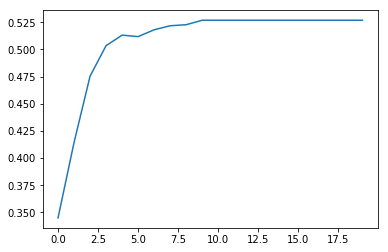

In [477]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(20)]);

#### Out-of-bag score

In [478]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[266.3874794003136, 261.05300194659884, 0.7444979888294381, 0.5380907052114776, 0.5702780198078039]


#### Subsampling

In [479]:
set_rf_samples(20000)

In [480]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 11.3 s, sys: 270 ms, total: 11.5 s
Wall time: 4.81 s
[322.21063186770823, 256.2004340914457, 0.6261938526871964, 0.5551034473455307, 0.5342231222878938]


#### Tree building parameters¶

In [481]:
reset_rf_samples()

In [482]:
m = RandomForestRegressor(n_estimators=10, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[303.42310968272284, 255.9558169508674, 0.6685148969604882, 0.5559526056888802, 0.5432360214686338]


#### Feature importance

In [483]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
24,bus_station_n,0.148227
84,shopping_mall_n,0.096212
60,local_government_office_n,0.071599
3,Day,0.058918
2,Week,0.054107
50,hair_care_n,0.053285
56,laundry_n,0.046355
67,movie_theater_n,0.046165
80,real_estate_agency_n,0.044078
57,lawyer_n,0.043218


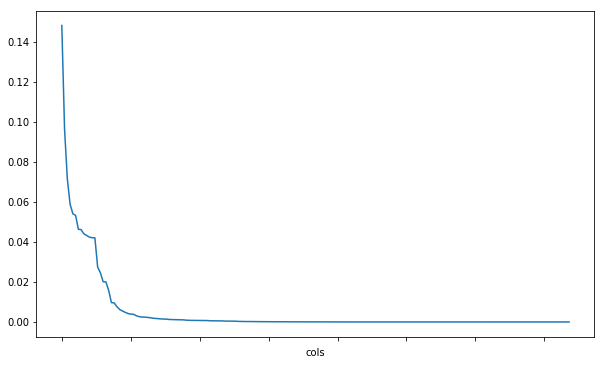

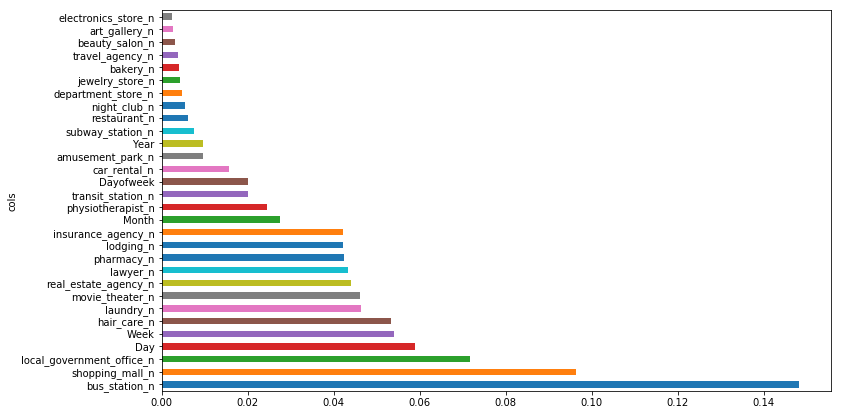

In [485]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [486]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

23

In [489]:
df_keep = df[to_keep].copy()
X_train_fi, X_valid_fi = split_vals(df, n_trn)

In [491]:
m = RandomForestRegressor(n_estimators=10, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train_fi, y_train)
print_score(m)

/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[300.7124418829854, 248.7279867802306, 0.6744111674196756, 0.5806770548822783, 0.5486225041694859]


#### Removing redundant features

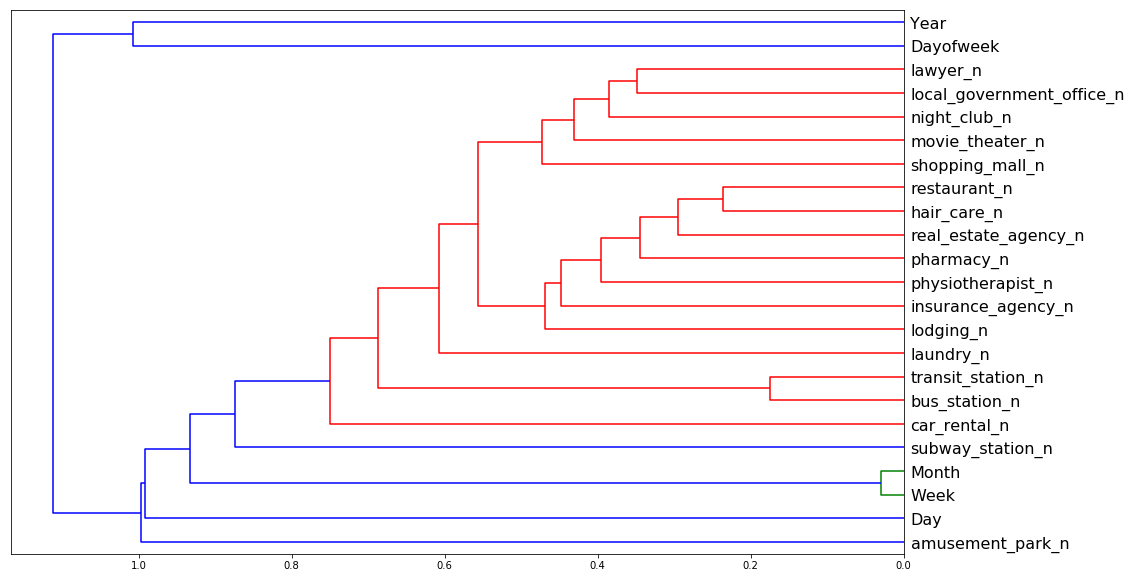

In [497]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [498]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=10, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [499]:
get_oob(df_keep)


/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.5532354005981196

In [502]:
for c in ('Week', 'Month', 'transit_station_n', 'bus_station_n'):
    print(c, get_oob(df_keep.drop(c, axis=1)))


/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Week 0.5576492036161932


/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Month 0.5338996842314466


/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


transit_station_n 0.5530038995232138
bus_station_n 0.5558778528400099


/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [507]:
to_drop = ['Week','bus_station_n']
get_oob(df_keep.drop(to_drop, axis=1))

/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.5707642859750331

In [508]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [509]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [512]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df[keep_cols]

reset_rf_samples()


In [513]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[303.45834638842445, 252.7946906630674, 0.6684379013667058, 0.5668530956675006, 0.5754959646400396]


#### Tree interpreter

In [516]:
from treeinterpreter import treeinterpreter as ti

In [517]:
df_train, df_valid = split_vals(df[df_keep.columns], n_trn)

In [518]:
row = X_valid.values[None,0]; row


array([[   1.,    0.,   13.,    1.,    0.,    0.,    1.,    0.,    1.,    0.,    0.,    4.,    3.,    2.,
           3.,    0.,    0., 2017.,    0.,    7.,    0.]])

In [519]:
prediction, bias, contributions = ti.predict(m, row)

In [520]:
prediction[0], bias[0]


(30.730952380952385, 117.30488399826538)

In [521]:
idxs = np.argsort(contributions[0])

In [522]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('pharmacy_n', 1.0, -15.135320922672602),
 ('local_government_office_n', 0.0, -14.303049534318154),
 ('physiotherapist_n', 3.0, -12.345896048353032),
 ('transit_station_n', 2.0, -12.118644187900447),
 ('real_estate_agency_n', 1.0, -11.973547115240656),
 ('hair_care_n', 1.0, -8.01181933960422),
 ('Year', 2017.0, -6.333017977387876),
 ('restaurant_n', 7.0, -4.553232003556315),
 ('car_rental_n', 0.0, -3.394146276563782),
 ('lawyer_n', 0.0, -3.2812750213174873),
 ('subway_station_n', 0.0, -2.5616304939190155),
 ('amusement_park_n', 0.0, -2.10740513634075),
 ('Dayofweek', 3.0, -1.9912468533909995),
 ('movie_theater_n', 0.0, -1.5174289152730744),
 ('lodging_n', 0.0, -0.7554577379901637),
 ('night_club_n', 0.0, -0.20687167440049598),
 ('insurance_agency_n', 0.0, -0.12708097057283138),
 ('Month', 4.0, 0.5412304320973885),
 ('laundry_n', 0.0, 0.6671020176930073),
 ('shopping_mall_n', 1.0, 1.7853319699632426),
 ('Day', 13.0, 11.149474171735244)]

#### Extrapolation

In [524]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [525]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9993113016399006

In [526]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,Month,0.577744
17,Year,0.279106
2,Day,0.133762
14,Dayofweek,0.002911
19,restaurant_n,0.002571
3,hair_care_n,0.001058
8,pharmacy_n,0.001023
12,physiotherapist_n,0.000330
13,transit_station_n,0.000274
6,real_estate_agency_n,0.000237


In [527]:
feats=['Month', 'Year', 'Day']
(X_train[feats]).describe()

,Month,Year,Day
count,83016.000000,83016.000000,83016.000000
mean,5.240086,2016.599535,15.452262
std,3.992431,0.489996,8.836025
min,1.000000,2016.000000,1.000000
25%,2.000000,2016.000000,8.000000
50%,3.000000,2017.000000,15.000000
75%,9.000000,2017.000000,23.000000
max,12.000000,2017.000000,31.000000


In [529]:
(X_valid[feats]).describe()

,Month,Year,Day
count,17173.000000,17173.0,17173.000000
mean,4.496710,2017.0,15.523263
std,0.500004,0.0,8.108662
min,4.000000,2017.0,1.000000
25%,4.000000,2017.0,9.000000
50%,4.000000,2017.0,16.000000
75%,5.000000,2017.0,22.000000
max,5.000000,2017.0,30.000000


In [530]:
x.drop(feats, axis=1, inplace=True)

In [531]:
m = RandomForestClassifier(n_estimators=10, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.8280649572308337

In [532]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
12,Dayofweek,0.236087
16,restaurant_n,0.145605
2,hair_care_n,0.088824
11,transit_station_n,0.079917
5,real_estate_agency_n,0.076068
8,lodging_n,0.064731
10,physiotherapist_n,0.054616
7,pharmacy_n,0.054315
9,insurance_agency_n,0.043439
6,lawyer_n,0.033625


In [533]:
df_subs = df_keep.drop(feats, axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=10, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/anaconda3/envs/pmi_interview/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[353.85834306635013, 246.76281866266433, 0.5491567361059859, 0.5872769134306374, 0.5340884547555361]


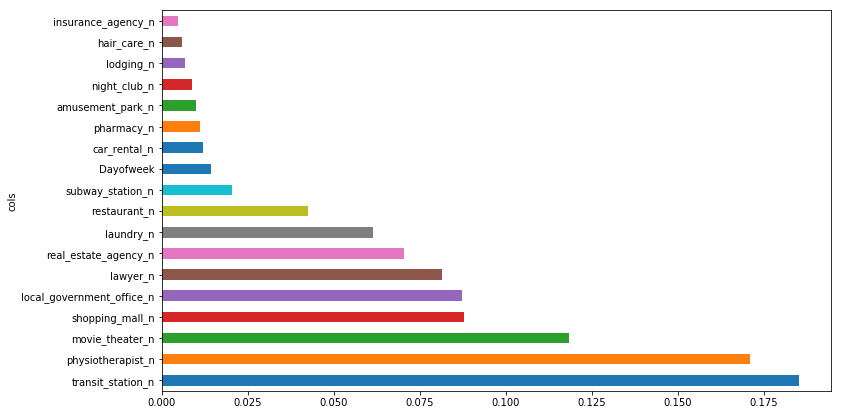

In [534]:
plot_fi(rf_feat_importance(m, X_train));

In [535]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

In [540]:
np.array(df_subs.columns)

array(['shopping_mall_n', 'local_government_office_n', 'hair_care_n', 'laundry_n', 'movie_theater_n',
       'real_estate_agency_n', 'lawyer_n', 'pharmacy_n', 'lodging_n', 'insurance_agency_n',
       'physiotherapist_n', 'transit_station_n', 'Dayofweek', 'car_rental_n', 'amusement_park_n',
       'subway_station_n', 'restaurant_n', 'night_club_n'], dtype=object)

### Second model:
Use volume per day, with time info (i.e. Dayofweek) and number of surrondings for each type, with the corresponding time they open and rating.

In [ ]:
final_with_time = df_aggregate_per_day_short_with_info_filter[flds].merge(metadata_with_days, how='left',on=['store_code','Dayofweek'])

In [ ]:
metadata_with_ratings = pd.concat([metadata_with_days.store_code, 
                                   metadata_with_days.Dayofweek, 
                                   metadata_with_days.filter(regex="_n"), 
                                   metadata_with_days.filter(regex="_mean_ratings")], axis = 1)
metadata_with_ratings.fillna(0, inplace=True)
final_with_time = df_aggregate_per_day_short_with_info_filter[flds].merge(metadata_with_ratings, how='left',on=['store_code','Dayofweek'])

## Test set 

In [543]:
X_test, y_test, nas = proc_df(df=test, y_fld='volume_day',skip_flds=['date','store_code'])
X_test = X_test[df_subs.columns]

preds = m.predict(X_test)

In [544]:
rmse(preds, y_test)

282.3029640740738

In [548]:
dump_session('tmp/postprocessing.pkl')